## Imports, Instalations and Constants

In [1]:
!pip install transformers

import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

pd.set_option('display.max_colwidth', None)
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'# This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2.
BATCH_SIZE = 16
N_EPOCHS = 3 # we can put more, because evaluation of the model shows big difference in loss with accuracy 1.0

     |████████████████████████████████| 2.8 MB 4.2 MB/s 
     |████████████████████████████████| 636 kB 36.7 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 895 kB 39.8 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## A common data set (with source text, preprocesses text, new features, and labels) before text-to-sequence transformation

We will take a column with not preprocecced text data for pure experiment with Hugging Face distilbert model

In [2]:
df = pd.read_csv('Processed_Data.csv',lineterminator='\n')
df

,Unnamed: 0,topic,tweet,sentiment,class,processed_tweets
0,0,#olympics,Aussies would be happy that the T20 series happened in the midst of #Olympics and not many took notice of it. Lost… https://t.co/us1T7Aj7qx,0.275000,Positive,aussie would happy series happen midst olympics not many take notice lose
1,1,#olympics,The worst thing about the #Olympics finishing is the whole week of @bbceastenders isn't available to download on a Monday morning anymore..,-0.133333,Negative,worst thing olympics finish whole week available download monday morning anymore
2,2,#olympics,#Olympics\n\nWe play for India: #Hockey captain #RaniRampal slams casteist abuse against #VandanaKatariya’s family\n\nT… https://t.co/3bAmAVopGa,0.000000,Neutral,olympics play india hockey captain ranirampal slam casteist abuse vandanakatariya family
3,3,#olympics,See the best moments from the #Tokyo2020 closing ceremony on VideoElephant TV. \n#Olympics #OlympicGames… https://t.co/pXbjJZJSoK,1.000000,Positive,see best moment tokyo close ceremony videoelephant tv olympics olympicgames
4,4,#olympics,Fabulous! #Olympics \n#LoveTheBBC \n\nTokyo Olympics: BBC Sport confirms record 104 million online viewing requests https://t.co/JclijHrD8g,0.500000,Positive,fabulous olympics lovethebbc tokyo olympics bbc sport confirm record million online view request
...,...,...,...,...,...,...
140242,140242,Tokyo olympics,"Congratulations to all our winners and participants at the Olympics. Winning and Losing the A Sport Is part of, But… https://t.co/Ai4UhoGEMz",0.500000,Positive,congratulation winner participant olympics win lose sport part
140243,140243,Tokyo olympics,"I hope that I am wrong but I have seen no tweets from our @theSNP government, @NicolaSturgeon @Ianblackford_MP or a… https://t.co/qo4dsYxple",-0.500000,Negative,hope wrong see tweet government
140244,140244,Tokyo olympics,Tokyo passes the baton to Paris as strangest ever Olympic Games come to an end https://t.co/xzIZDAvbNg,0.000000,Neutral,tokyo pass baton paris strangest ever olympic game come end
140245,140245,Tokyo olympics,"Paris plans to deliver inclusive, youth-centred and gender-equal Games in 2024 https://t.co/mr6CsjDdt7",0.000000,Neutral,paris plan deliver inclusive youth centre gender equal game


In [3]:

df = df.dropna()
df = df[df['processed_tweets'].apply(lambda x: x !="")]
df.shape

(139715, 6)

In [4]:
def ratio(x):
  if x=='Positive':
    return 1
  else:
    return 0;

In [5]:
df['label'] = df['class'].apply(ratio)
df

,Unnamed: 0,topic,tweet,sentiment,class,processed_tweets,label
0,0,#olympics,Aussies would be happy that the T20 series happened in the midst of #Olympics and not many took notice of it. Lost… https://t.co/us1T7Aj7qx,0.275000,Positive,aussie would happy series happen midst olympics not many take notice lose,1
1,1,#olympics,The worst thing about the #Olympics finishing is the whole week of @bbceastenders isn't available to download on a Monday morning anymore..,-0.133333,Negative,worst thing olympics finish whole week available download monday morning anymore,0
2,2,#olympics,#Olympics\n\nWe play for India: #Hockey captain #RaniRampal slams casteist abuse against #VandanaKatariya’s family\n\nT… https://t.co/3bAmAVopGa,0.000000,Neutral,olympics play india hockey captain ranirampal slam casteist abuse vandanakatariya family,0
3,3,#olympics,See the best moments from the #Tokyo2020 closing ceremony on VideoElephant TV. \n#Olympics #OlympicGames… https://t.co/pXbjJZJSoK,1.000000,Positive,see best moment tokyo close ceremony videoelephant tv olympics olympicgames,1
4,4,#olympics,Fabulous! #Olympics \n#LoveTheBBC \n\nTokyo Olympics: BBC Sport confirms record 104 million online viewing requests https://t.co/JclijHrD8g,0.500000,Positive,fabulous olympics lovethebbc tokyo olympics bbc sport confirm record million online view request,1
...,...,...,...,...,...,...,...
140242,140242,Tokyo olympics,"Congratulations to all our winners and participants at the Olympics. Winning and Losing the A Sport Is part of, But… https://t.co/Ai4UhoGEMz",0.500000,Positive,congratulation winner participant olympics win lose sport part,1
140243,140243,Tokyo olympics,"I hope that I am wrong but I have seen no tweets from our @theSNP government, @NicolaSturgeon @Ianblackford_MP or a… https://t.co/qo4dsYxple",-0.500000,Negative,hope wrong see tweet government,0
140244,140244,Tokyo olympics,Tokyo passes the baton to Paris as strangest ever Olympic Games come to an end https://t.co/xzIZDAvbNg,0.000000,Neutral,tokyo pass baton paris strangest ever olympic game come end,0
140245,140245,Tokyo olympics,"Paris plans to deliver inclusive, youth-centred and gender-equal Games in 2024 https://t.co/mr6CsjDdt7",0.000000,Neutral,paris plan deliver inclusive youth centre gender equal game,0


In [6]:
x = df['processed_tweets']
y = df['label']
print(x.shape)
print(y.shape)

(139715,)
(139715,)


In [7]:
from sklearn.model_selection import train_test_split as tts

In [8]:
X_train,X_test,y_train,y_test = tts(x,y,test_size = 0.05)

In [9]:

#train = pd.read_pickle('https://github.com/Galina-Blokh/ai_assignment_aidock/blob/refator/data/new_train_data_clean.pkl?raw=true')
#test = pd.read_pickle('https://github.com/Galina-Blokh/ai_assignment_aidock/blob/refator/data/new_test_data_clean.pkl?raw=true')

#X_train =train.paragraph
##X_test =test.paragraph
#y_train = train.label
#y_test = test.label 

pd.DataFrame(X_train)[:3]

,processed_tweets
133307,bcci announce cash reward india medal winner tokyo olympics bcci would give cash reward
94565,saw result japan beat usa woooooooooow come guy olympics
11669,post olympics watch cheer depression real tokyo


## check the shapes and split proportion 

In [10]:
X_train.shape, X_test.shape, y_train.shape

((132729,), (6986,), (132729,))

In [11]:
print('The proportion in y_train\n',y_train.value_counts(normalize=True).mul(100))
print('The proportion in y_test\n',y_test.value_counts(normalize=True).mul(100))

The proportion in y_train
 0    52.131787
1    47.868213
Name: label, dtype: float64
The proportion in y_test
 0    53.235042
1    46.764958
Name: label, dtype: float64


### Max sentence length

In [12]:
MAX_LEN = X_train.apply(lambda s: len([x for x in s.split()])).max()
MAX_LEN

24

## Encode with  DistilBertTokenizer

In [13]:
#define a tokenizer object
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

#tokenize the text (padding to max sequence in batch)
train_encodings = tokenizer(list(X_train.values), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test.values), truncation=True, padding=True)

#print the first paragraph and it transformation
print(f'First paragraph: \'{X_train[:1]}\'')
print(f'Input ids: {train_encodings["input_ids"][0]}')
print(f'Attention mask: {train_encodings["attention_mask"][0]}')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

First paragraph: '133307    bcci announce cash reward india medal winner tokyo olympics bcci would give cash reward
Name: processed_tweets, dtype: object'
Input ids: [101, 4647, 6895, 14970, 5356, 10377, 2634, 3101, 3453, 5522, 3783, 4647, 6895, 2052, 2507, 5356, 10377, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Length check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b02305410>,
      dtype=object)

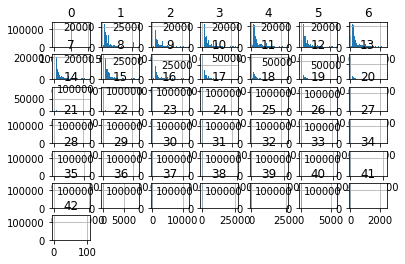

In [15]:
pd.DataFrame(train_encodings["input_ids"]).hist(bins = 50)

In [16]:
len(train_encodings["attention_mask"][0]) #max len tokenized sentence - 362

43

In [17]:
train_encodings

###  Turn our labels and encodings into a tf.Dataset object

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    list(y_train.values)))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    list(y_test.values)))

In [19]:
train_dataset 

<TensorSliceDataset shapes: ({input_ids: (43,), attention_mask: (43,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

## Fine-tuning with native TensorFlow


In [20]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

optimizerr = tf.keras.optimizers.Adam(learning_rate=5e-5)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions. 
model.compile(optimizer=optimizerr,                                     
              loss=losss,
              metrics=['accuracy'])

model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE), 
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

## Model Evaluation

In [21]:
model.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

437/437 [==============================] - 26s 55ms/step - loss: 0.1923 - accuracy: 0.9505


{'accuracy': 0.950472354888916, 'loss': 0.19230963289737701}